# Audio Effects Classifier Example

To demonstrate how to use the [IDMT-SMT-Audio Effects](https://mirdata.readthedocs.io/en/stable/source/mirdata.html#module-mirdata.datasets.idmt_smt_audio_effects) data loader available in mirdata, this Jupyter notebook goes through the process of training a simple audio effects classifier using the [PyTorch](https://pytorch.org/) framework.

The dataset contains 55041 audio files, a detailed description of the dataset can be found [here](https://www.idmt.fraunhofer.de/en/business_units/m2d/smt/audio_effects.html) and an [english version](idmt_smt_audio_effects_readme.md) of the ReadMe file is attached to this notebook in the same folder.

Author: [Francesco Papaleo](https://github.com/francescopapaleo) | November 2024

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francescopapaleo/mirdata-notebooks/blob/master/idmt_smt_audio_effects/audio_effects_classifier.ipynb)

In [122]:
#@title Install dependencies

%pip install mirdata torchinfo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/gdrive')

In [124]:
#@title Imports

import os
import shutil
import numpy as np
import mirdata
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader
from scipy import signal
from torchinfo import summary
from pathlib import Path

from sklearn.metrics import confusion_matrix

print(mirdata.__version__)

0.3.8


In [125]:
# @title Helper functions for plotting

def plot_waveform(waveform: np.ndarray, sr: int, title="Waveform", ax=None):
    if waveform.ndim == 2:
        num_channels, num_frames = waveform.shape
    else:
        num_channels, num_frames = 1, waveform.shape[0]

    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots()

    if num_channels == 1:
        ax.plot(time_axis, waveform, linewidth=1)
    else:
        ax.plot(
            time_axis, waveform[0], linewidth=1
        )  # Assuming you want to plot the first channel

    ax.grid(True)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(
    waveform: np.ndarray, sr: int = None, title="Spectrogram", ax=None
):
    if waveform.ndim == 2:
        waveform = waveform[0]  # If stereo, take only the first channel

    # Compute the STFT
    f, t, Zxx = signal.stft(waveform, fs=sr)

    # Convert to magnitude (spectrogram)
    specgram = np.abs(Zxx)

    # Plotting
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot the spectrogram
    ax.imshow(
        20 * np.log10(specgram + 1e-10),
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="inferno",
    )
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(title)

    if sr is not None:
        ax.set_ylim(0, sr / 2)  # Limit frequency axis to Nyquist frequency

In [152]:
#@title set the mirdata download directory

DATA_HOME = "/Users/francescopapaleo/mir_datasets/idmt_smt_audio_effects/"

In [127]:
#@title Initialize the dataset
idmt_smt_audio_effects = mirdata.initialize("idmt_smt_audio_effects", data_home=DATA_HOME)
print(idmt_smt_audio_effects.data_home)

/Users/francescopapaleo/mir_datasets/idmt_smt_audio_effects/


In [128]:
#@title Download the dataset
idmt_smt_audio_effects.download(force_overwrite=False, cleanup=True)

In [129]:
#@title Validate the dataset
idmt_smt_audio_effects.validate()

100%|██████████| 55044/55044 [01:36<00:00, 568.56it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

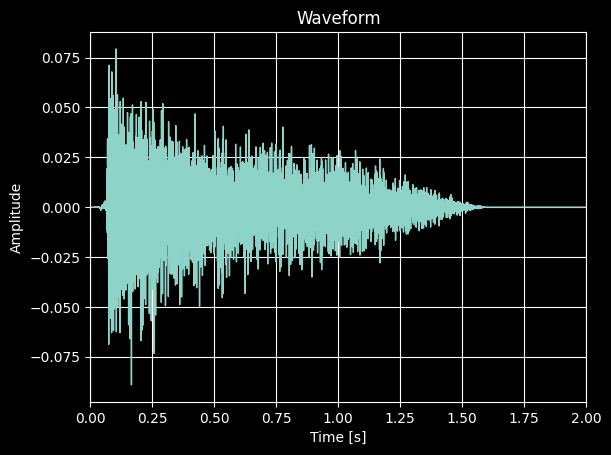

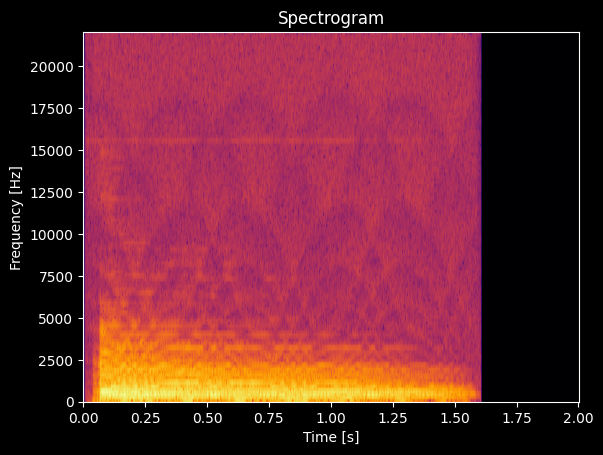

In [153]:
#@title Select a random track and plot the waveform and spectrogram

track = idmt_smt_audio_effects.choice_track()
x, sr = track.audio

plot_waveform(x, sr)
plot_spectrogram(x, sr)

In [155]:
#@title Custom dataset class for the IDMT-SMT-Audio-Effects dataset

class IDMTSMTAudioEffectsDataset(Dataset):
    def __init__(
        self,
        mirdataset,
        train_split=0.8,
        test_split=0.2,
        split_type='train',
        random_seed=23,
        transform=None,
    ):
        self.dataset = mirdataset
        self.transform = transform

        # Set random seed for reproducibility
        torch.manual_seed(random_seed)

        num_tracks = len(self.dataset.track_ids)
        indices = torch.randperm(num_tracks)

        split_index = int(num_tracks * train_split)
        if split_type == 'train':
            selected_indices = indices[:split_index]
        elif split_type == 'test':
            selected_indices = indices[split_index:]
        else:
            raise ValueError("split_type must be 'train' or 'test'")

        # Map the selected indices to track IDs
        self.track_ids = [self.dataset.track_ids[i] for i in selected_indices.tolist()]


    def __getitem__(self, idx):
        track_id = self.track_ids[idx]
        track = self.dataset.track(track_id)

        # Load audio data
        audio_tensor, sr = torchaudio.load(track.audio_path)

        # Apply transforms if needed
        if self.transform:
            audio = self.transform(waveform)

        label_map = {
            11: 0,  # No effect
            12: 1,  # No Effect, amplifier simulation
            21: 2,  # Feedback Delay
            22: 3,  # Slapback Delay
            23: 4,  # Reverb
            31: 5,  # Chorus
            32: 6,  # Flanger
            33: 7,  # Phaser
            34: 8,  # Tremolo
            35: 9,  # Vibrato
            41: 10,  # Distortion
            42: 11,  # Overdrive
        }

        label = label_map.get(
            track.fx_type, -1
        )  # Default to -1 if fx_type is not found

        return audio_tensor, label

    def __len__(self):
        return len(self.track_ids)

In [156]:
#@title Set the dataset parameters

BATCH_SIZE = 8
NUM_WORKERS = 0

In [133]:
#@title Initialize the dataset

train_dataset = IDMTSMTAudioEffectsDataset(mirdataset=idmt_smt_audio_effects, split_type='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

test_dataset = IDMTSMTAudioEffectsDataset(mirdataset=idmt_smt_audio_effects, split_type='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Number of training samples: 44035
Number of test samples: 11009


In [157]:
#@title Define a simple feed-forward classifier

class FeedForwardAudioFxClassifier(nn.Module):
    def __init__(self,
                 input_size: int,       
                 output_size: int = 12, # Number of classes (fx_type)
                 hidden_size: int = 128, # Number of hidden units
                 ):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # Define the fully connected layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size * 2)  # Double the hidden size
        self.fc3 = nn.Linear(self.hidden_size * 2, self.hidden_size * 2)  # Keep the doubled size
        self.fc4 = nn.Linear(self.hidden_size * 2, self.output_size)  # Output layer

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        x = F.relu(self.fc1(x))          # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))          # Second hidden layer with ReLU activation
        x = F.relu(self.fc3(x))          # Third hidden layer with ReLU activation
        x = self.fc4(x)                  # Output layer, no activation here
        return x

# Example usage
ff_model = FeedForwardAudioFxClassifier(input_size=x.shape[0], output_size=12)
summary(ff_model, input_size=(BATCH_SIZE, 1, x.shape[0]))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardAudioFxClassifier             [8, 12]                   --
├─Linear: 1-1                            [8, 128]                  11,289,856
├─Linear: 1-2                            [8, 256]                  33,024
├─Linear: 1-3                            [8, 256]                  65,792
├─Linear: 1-4                            [8, 12]                   3,084
Total params: 11,391,756
Trainable params: 11,391,756
Non-trainable params: 0
Total mult-adds (M): 91.13
Input size (MB): 2.82
Forward/backward pass size (MB): 0.04
Params size (MB): 45.57
Estimated Total Size (MB): 48.43

In [135]:
#@title Define a simple Convolutional classifier

class ConvAudioFxClassifier(nn.Module):
    def __init__(self,
                 n_input: int = 1,       
                 n_output: int = 12, # Number of classes (fx_type)
                 stride: int = ..., # 
                 n_channels: int = 128, # 
                 ):
        super().__init__()
        """
        Inspired by the M5 model from:
        https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
        """

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_input, n_channels, kernel_size=80, stride=16)
        self.bn1 = nn.BatchNorm1d(n_channels)
        self.pool1 = nn.MaxPool1d(3, stride=16)
        self.conv2 = nn.Conv1d(n_channels, n_channels, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(n_channels)
        self.pool2 = nn.MaxPool1d(3, stride=8)
        self.conv3 = nn.Conv1d(n_channels, 2 * n_channels, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(2 * n_channels)
        self.pool3 = nn.MaxPool1d(3, stride=8)
        self.conv4 = nn.Conv1d(2 * n_channels, 2 * n_channels, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channels)
        self.pool4 = nn.MaxPool1d(3, stride=4)

        self.fc1 = nn.Linear((2 * n_channels), n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x

conv_model = ConvAudioFxClassifier()
summary(conv_model, input_size=(BATCH_SIZE, 1, x.shape[0]))

Layer (type:depth-idx)                   Output Shape              Param #
ConvAudioFxClassifier                    [8, 12]                   --
├─Conv1d: 1-1                            [8, 128, 5508]            10,368
├─BatchNorm1d: 1-2                       [8, 128, 5508]            256
├─MaxPool1d: 1-3                         [8, 128, 345]             --
├─Conv1d: 1-4                            [8, 128, 343]             49,280
├─BatchNorm1d: 1-5                       [8, 128, 343]             256
├─MaxPool1d: 1-6                         [8, 128, 43]              --
├─Conv1d: 1-7                            [8, 256, 41]              98,560
├─BatchNorm1d: 1-8                       [8, 256, 41]              512
├─MaxPool1d: 1-9                         [8, 256, 5]               --
├─Conv1d: 1-10                           [8, 256, 3]               196,864
├─BatchNorm1d: 1-11                      [8, 256, 3]               512
├─MaxPool1d: 1-12                        [8, 256, 1]            

In [136]:
#@title Training loop

def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return epoch_loss


In [137]:
#@title Instantiate the models, loss function and optimizer and call the training loop

NUM_EPOCHS = 10 # Number of training epochs

criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default choice)
ff_optim = torch.optim.Adam(ff_model.parameters(), lr=0.001)
conv_optim = torch.optim.Adam(conv_model.parameters(), lr=0.001)

# Now, train each model for 1 epoch and compare their performance
loss_ff = train_model(ff_model, train_loader, criterion, ff_optim, num_epochs=NUM_EPOCHS)
loss_conv = train_model(conv_model, train_loader, criterion, conv_optim, num_epochs=NUM_EPOCHS)

print(f"FeedForward Model Loss: {loss_ff}")
print(f"Convolutional Model Loss: {loss_conv}")

Epoch [1/10], Loss: 2.1067
Epoch [2/10], Loss: 1.8126
Epoch [3/10], Loss: 1.6624
Epoch [4/10], Loss: 1.5631
Epoch [5/10], Loss: 1.4850
Epoch [6/10], Loss: 1.4100
Epoch [7/10], Loss: 1.3556
Epoch [8/10], Loss: 1.3006
Epoch [9/10], Loss: 1.2637
Epoch [10/10], Loss: 1.2068
Epoch [1/10], Loss: 1.6151
Epoch [2/10], Loss: 1.2019
Epoch [3/10], Loss: 1.0118
Epoch [4/10], Loss: 0.8712
Epoch [5/10], Loss: 0.7550
Epoch [6/10], Loss: 0.6509
Epoch [7/10], Loss: 0.5586
Epoch [8/10], Loss: 0.4776
Epoch [9/10], Loss: 0.4075
Epoch [10/10], Loss: 0.3525
FeedForward Model Loss: 1.2067616371838858
Convolutional Model Loss: 0.35251215854416484


In [158]:
#@title Function to plot a confusion matrix

def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [149]:
#@title Test the models on the test set

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Append predictions and labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return all_predictions, all_labels, accuracy


FeedForward Model Accuracy: 43.46%
Convolutional Model Accuracy: 70.57%


Text(0.5, 1.0, 'Convolutional Model Confusion Matrix')

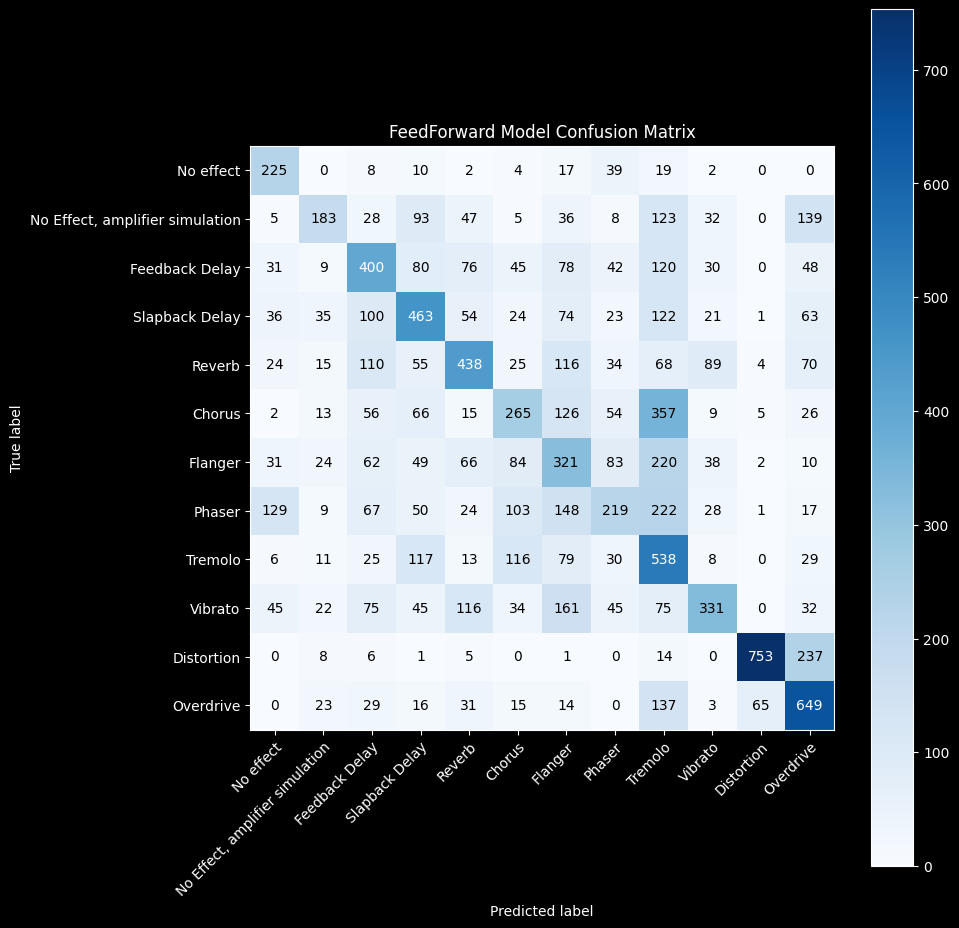

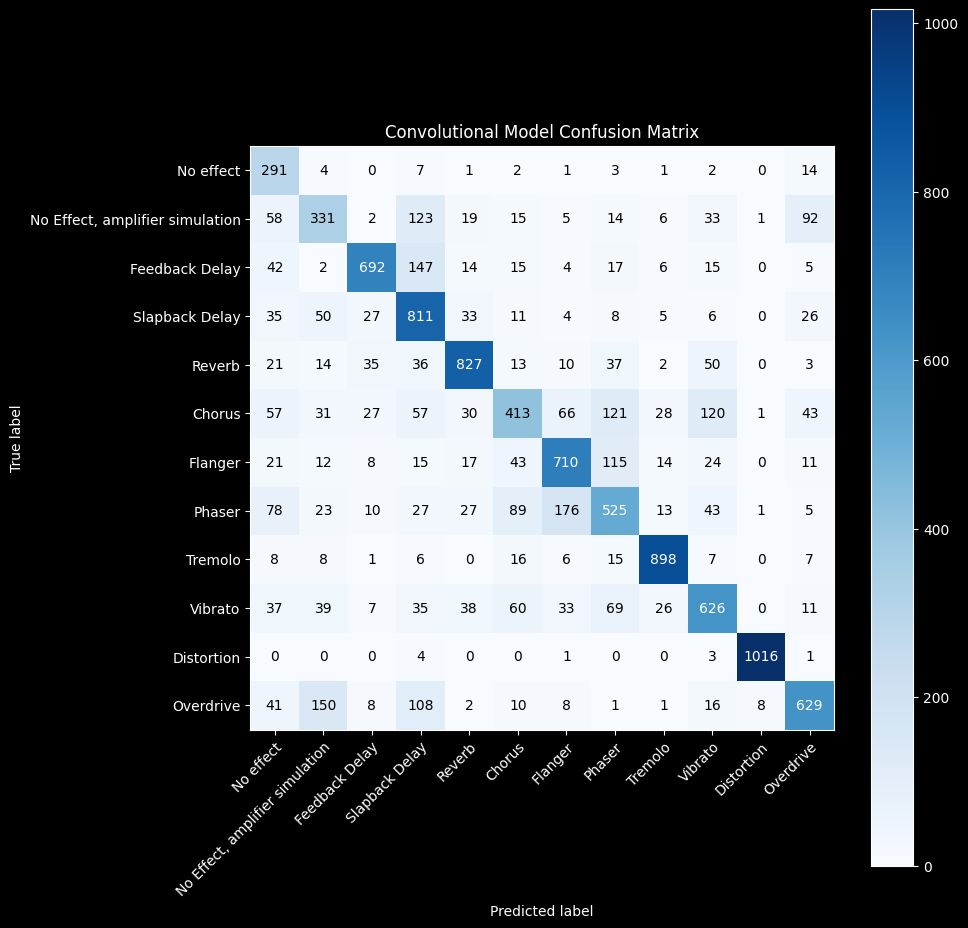

In [150]:
# Get predictions, labels, and accuracy from the feed-forward model
ff_predictions, ff_labels, ff_accuracy = test_model(ff_model, test_loader)
print(f"FeedForward Model Accuracy: {ff_accuracy:.2f}%")
plot_confusion_matrix(ff_labels, ff_predictions, class_names)
plt.title("FeedForward Model Confusion Matrix")

# Get predictions, labels, and accuracy from the convolutional model
conv_predictions, conv_labels, conv_accuracy = test_model(conv_model, test_loader)
print(f"Convolutional Model Accuracy: {conv_accuracy:.2f}%")
plot_confusion_matrix(conv_labels, conv_predictions, class_names)
plt.title("Convolutional Model Confusion Matrix")
